In [1]:
import os
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import pandas as pd
import datetime
from mpl_toolkits.mplot3d import Axes3D, axes3d

# import pandas as pd
import xarray as xr
from scipy import signal, integrate

import subroutines
import vis_eulag

plt.style.use('latex_default.mplstyle')

In [2]:
SETTINGS = vis_eulag.load_settings('settings_local_translb.txt')
fileLocations = ['/work/bd0620/b309199/translbq3D/translbq3D_002']
                 
ds_list = []
for fileLocation in fileLocations:
    env_fileName = "env.nc"
    tapes_fileName = "tapes.nc" # "tapes.nc"
    grid_fileName = "grd.nc"
    env_path = os.path.join(fileLocation, env_fileName)
    tapes_path = os.path.join(fileLocation, tapes_fileName)
    grid_path = os.path.join(fileLocation, grid_fileName)

    ds = xr.open_dataset(tapes_path) #, decode_times=False)
    # DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km
    # DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature) # Change 0 to NaN

    ds_grid = xr.open_dataset(grid_path)
    ds_env = xr.open_dataset(env_path)

    if len(ds.w.shape) == 3: # 2D case
        # ds_env['time'] = ds['time']
        ds = ds.drop('time')
        ds['ELEVATION'] = ds['ELEVATION'].expand_dims({'t':ds.t})
        # ds = ds.drop('ELEVATION')
        ds = ds.expand_dims('y',axis=2)

    if len(ds_env.ue.shape) == 3: # not time depedant case
        ds_env = ds_env.expand_dims({'t':ds.t})

    ds = ds.assign_coords({'xcr':ds_grid['xcr']/1000, 'zcr':ds_env['zcr']/1000, 'ycr':ds_grid['ycr']/1000,
                          'zs':ds_grid['zs']/1000, 'zh':ds_grid['zh']/1000, 'gi':ds_grid['gi']})
    ds_env = ds_env.drop('zcr')
    ds = ds.merge(ds_env)

    # ---- Sim parameters -------------- # 
    ds.attrs = ds_grid.attrs
    ds.attrs['bv'] = ds.attrs['bv'].round(3)
    ds.attrs['u00'] = ds['ue'][0,0,0,0].values
    ds.attrs['v00'] = ds['ve'][0,0,0,0].values
    ds.attrs['nx'] = np.shape(ds['w'])[3]
    ds.attrs['ny'] = np.shape(ds['w'])[2]
    ds.attrs['nz'] = np.shape(ds['w'])[1]
    
    ds = subroutines.dzdx_topo(ds)
    # ---- Sim parameters -------------- # 

    # ---- Constants ------------------- #
    pref00=101325.
    # pref00=23700.
    ds.attrs['cp']=3.5*ds.rg # Earth
    ds.attrs['grav']=ds.g
    ds.attrs['cap']=ds.rg/ds.cp
    ds.attrs['capi'] =1/ds.cap
    ds.attrs['capp']=1-ds.cap # Cv/Cp
    ds.attrs['cappi']=1/ds.capp   # Cp/Cv
    ds.attrs['compri']=ds.rg/pref00**ds.cap
    # ---- Constants ------------------- # 

    # ---- IDL code of AD -------------- # 
    # Forces (MF_x, EF_z, EF_x)
    # h1: ttt (theta)
    # h2: tloc-tte with tloc = thloc*(ploc/pref00)^cap
    # h3: wprime = w
    # h4: tprime+the
    # h5: sqrt(uprime^2+vprime^2)
    # h6: uprime
    # h7: ploc or h12-h12(100), h12=p
    # h9: MFx
    # h11: EFx
    # h12: pprime filtered
    # ---- IDL code of AD -------------- #

    # ---- Perturbations -- #
    # Uncomment line that suits available data
    # ds['uprime'] = ds['u'] - ds['u'][:,:,:,0] # time-dependant background state
    # ds['uprime'] = ds['u'] - ds['ue']

    # ds['vprime'] = ds['v'] - ds['ve'][:,:,:,0] # time-dependant background state
    # ds['vprime'] = ds['v'] - ds['ve']

    # ds['wprime'] = ds['w']
    
    # ---- Pressure ------- #
    ds['pref00'] = ds['pr0'].max() # Pa pref00=101325.
    # p is pressure perturbation output from EULAG
    # h12 is 2D filtered
    # h7 additionally referenced to x-location before mtn
    # ppe=(rhe*the*compri)^cappi
    ds['pprime']=ds['p'] # h12
    # ds['pprime']=filt_2dx(ds['p'],1) # h12
    # ds['pprime']=filt_2dx(ds['p'],0) # h12
    # ds['ploc'] = ds['pprime'] + ds['pr0']
    # ds['h7'] = ds['pprime'] - ds['pprime'][:,:,:,100] # x=100 before mtn?

    ds_cp = ds.copy()
    ds_list.append(ds_cp)
ds

<xarray.Dataset>
Dimensions:    (t: 7, z: 301, y: 72, x: 720)
Coordinates:
    xcr        (y, x) float32 0.0 15.0 30.0 ... 1.076e+04 1.077e+04 1.078e+04
    zcr        (t, z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 75.0 75.0 75.0 75.0
    ycr        (y, x) float32 -2.13e+03 -2.13e+03 ... 2.13e+03 2.13e+03
    zs         (y, x) float32 -0.0 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
    zh         (y, x) float32 75.0 75.0 75.0 75.0 75.0 ... 75.0 75.0 75.0 75.0
    gi         (y, x) float32 ...
Dimensions without coordinates: t, z, y, x
Data variables: (12/20)
    time       (t) float32 ...
    u          (t, z, y, x) float32 ...
    v          (t, z, y, x) float32 ...
    w          (t, z, y, x) float32 ...
    th         (t, z, y, x) float32 ...
    p          (t, z, y, x) float32 ...
    ...         ...
    rh0        (t, z, y, x) float32 ...
    pr0        (t, z, y, x) float32 2.372e+04 2.372e+04 ... 0.5273 0.5273
    ppe        (t, z, y, x) float32 ...
    dzdx_surf  (y, x) float32 -0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 -0.0
    pref00     float64 2.641e+04
    pprime     (t, z, y, x) float32 ...
Attributes: (12/54)
    nt:           4320
    nplot:        720
    nstore:       100000
    nlid:         5
    dt00:         60.0
    dx00:         15000.0
    ...           ...
    grav:         9.80616
    cap:          0.2857142857142857
    capi:         3.5
    capp:         0.7142857142857143
    cappi:        1.4
    compri:       10.659520642663725

In [3]:
ds.dz00

250.0

In [10]:
ds.fcr0*np.sin(ds.ang*np.pi/180)

-0.00011946513413910657

1660.0
1660.0
1660.0


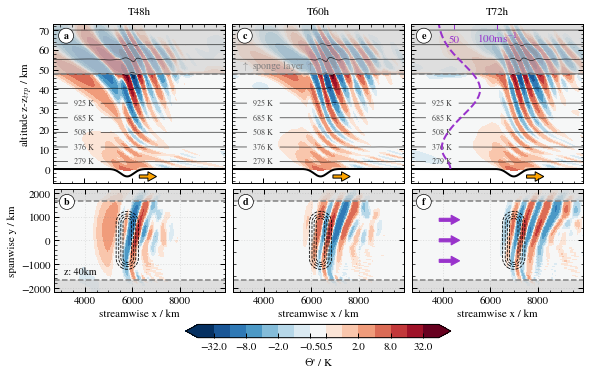

In [8]:
# gskw = {'hspace':0.001}
# gskw = {'hspace':0.07, 'wspace':0.1, 'height_ratios': [5,4]}
gskw = {'hspace':0.08, 'wspace':0.04, 'height_ratios': [6.2,4,0.8,1]}
fig, axes = plt.subplots(4,3,figsize=(9.5,6),sharex=True,gridspec_kw=gskw)
# ((ax0,ax1,ax2),(ax3,ax4,ax5))

axes[2,0].set_axis_off()
axes[2,1].set_axis_off()
axes[2,2].set_axis_off()
axes[3,0].set_axis_off()
axes[3,1].set_axis_off()
axes[3,2].set_axis_off()

# --- SET TIME, Y, ... #
ds = ds_list[0]
y=int(ds.ny/2)
# tvec=[4,5,6]
z=133 # 40km
z_l = 40

XLIM = [2700,9900]
ZLIM = [-7,73]
# ZLIM = [-7,73]
t_max = np.shape(ds.th)[0]

cmap = plt.get_cmap('RdBu_r')
clev, clev_l = subroutines.get_colormap_bins_and_labels(max_level=64)
norm = BoundaryNorm(boundaries=clev , ncolors=cmap.N, clip=True)

numb_str = ['a','b','c','d','e','f']
k=0
t=4
for j in range(0,3):
    if t >= t_max:
        continue
    
    i=0 # vertical cross-section
    pcMesh0 = axes[i,j].pcolormesh(ds.xcr[y], ds.zcr[t,:,y,:], ds.th[t,:,y,:],
                                cmap=cmap, norm=norm, shading='nearest')
    time_label = 'T' + str(t*12) + 'h'
    axes[i,j].set_title(time_label,pad=10)
    axes[i,j] = subroutines.format_xz_plot(ds, SETTINGS, axes[i,j], t, y=y)
    # axes[i,j].set_aspect(0.66)
    
    if j==0:
        axes[i,j].set_ylabel(r'altitude z-z$_{trp}$ / km')
    
    if t==6:
        ax_wind = axes[i,j].twiny()
        x=0
        c4='darkorchid'
        ax_wind.plot(ds['ue'][t,:,y,x], ds.zcr[t,:,y,x], lw=2, color=c4, ls='--', label='$u_e$')
        # ax_wind.set_xlabel('$\hat{u}$ / m s$^{-1}$')
        
        # ax_wind.tick_params(axis='x', which='both', top=False)
        ax_wind.set_xlim([0,200])
        # ax_wind.xaxis.set_minor_locator(AutoMinorLocator())
        wind_xticks = ax_wind.get_xticks()
        plt.xticks(wind_xticks[1:3], labels=['50', '100ms$^{-1}$'], visible=True)
        ax_wind.tick_params(axis="x",direction="in", pad=-20, colors=c4, labelbottom=False)
        ax_wind.xaxis.label.set_color(c4)
    
    axes[i,j].set_ylim(ZLIM)
    
    # - Sponge layer - #
    c3 = 'lightgrey'
    zu = 73
    alpha_sponge = 0.67
    axes[i,j].axhline(y=48, lw=1.5,ls='--',color='grey')
    axes[i,j].fill_between(XLIM, [zu,zu], [48,48], facecolor=c3, alpha=alpha_sponge)
    
    axes[i,j].text(0.06, 0.91, numb_str[k], transform=axes[i,j].transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    k=k+1
    
    ### --- horizontal cross-section --- ####
    i=1
    pcMesh = axes[i,j].pcolormesh(ds.xcr, ds.ycr, ds.th[t,z,:,:],
                                     cmap=cmap, norm=norm, shading='nearest')
    axes[i,j].tick_params(axis="x", labelbottom=True)
    axes[i,j] = subroutines.format_xy_plot(ds, SETTINGS, axes[i,j], t, z=z)
    axes[i,j].axis('scaled')
    axes[i,j].set_xlabel('streamwise x / km')
    
    if j==0:
        axes[i,j].set_ylabel('spanwise y / km')
    
    # - Sponge layer - #
    ymax = int(ds.ny/2)*ds.dy00/1000
    ysponge = (int(ds.ny/2)*ds.dy00-ds.dyab)/1000
    print(ysponge)
    axes[i,j].axhline(y=ysponge, lw=1.5,ls='--',color='grey')
    axes[i,j].axhline(y=-ysponge, lw=1.5,ls='--',color='grey')
    axes[i,j].fill_between(XLIM, [ymax,ymax], [ysponge,ysponge], facecolor=c3, alpha=alpha_sponge)
    axes[i,j].fill_between(XLIM, [-ymax,-ymax], [-ysponge,-ysponge], facecolor=c3, alpha=alpha_sponge)
    
    axes[i,j].grid()
    axes[i,j].text(0.06, 0.85, numb_str[k], transform=axes[i,j].transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    k=k+1
    
    t=t+1

axes[0,1].tick_params(labelleft=False)
axes[1,1].tick_params(labelleft=False)
axes[0,2].tick_params(labelleft=False)
axes[1,2].tick_params(labelleft=False)

fig.canvas.draw()
axes[1,0].text(0.06,0.17, 'z: 40km', transform=axes[1,0].transAxes)
#height_tick = axes[0,0].get_yticks()
#height_tick_labels = axes[0,0].get_yticklabels()
#height_tick_labels[1] = r"0 (z$_{trp}$)"
#axes[0,0].set_yticks(height_tick)
#axes[0,0].set_yticklabels(height_tick_labels)
axes[0,0].set_ylim(ZLIM)
axes[1,0].set_yticks([-2000,-1000,0,1000,2000])

axes[0,0].arrow(0.5, 0.04, 0.05, 0, width = 0.02, head_length=0.05, transform=axes[0,0].transAxes,  facecolor='orange', edgecolor='black')
axes[0,1].arrow(0.585, 0.04, 0.05, 0, width = 0.02, head_length=0.05, transform=axes[0,1].transAxes,  facecolor='orange', edgecolor='black')
axes[0,2].arrow(0.67, 0.04, 0.05, 0, width = 0.02, head_length=0.05, transform=axes[0,2].transAxes,  facecolor='orange', edgecolor='black')
axes[1,2].arrow(0.16, 0.3, 0.07, 0, width = 0.03, head_length=0.05, transform=axes[1,2].transAxes,  facecolor=c4, edgecolor=c4)
axes[1,2].arrow(0.16, 0.5, 0.07, 0, width = 0.03, head_length=0.05, transform=axes[1,2].transAxes,  facecolor=c4, edgecolor=c4)
axes[1,2].arrow(0.16, 0.7, 0.07, 0, width = 0.03, head_length=0.05, transform=axes[1,2].transAxes,  facecolor=c4, edgecolor=c4)


# - Sponge text - #
sponge_label = r'$\uparrow$ sponge layer $\uparrow$'
axes[0,1].text(0.05, 0.72, sponge_label, transform=axes[0,1].transAxes, color='grey')

axes[0,0].set_xlim(XLIM)
cbar = fig.colorbar(pcMesh0, ax=axes[3,:], location='bottom', shrink=0.5, fraction=1, ticks=clev_l, extend='both')
cbar.set_label(r"$\Theta$' / K")
# cbar.ax.tick_params(labelsize=9)

# --- Save figure --- #
# fig.suptitle(title_label)
fig_name = 'Q3D-th-referenceSim.png'
fig.tight_layout()
fig.savefig('../figures/' + fig_name, facecolor='w', edgecolor='w',
                format='png', dpi=450, bbox_inches='tight')
plt.show()

xfilter:  495.0
zfilter:  12.0
-0.00011946513413910657


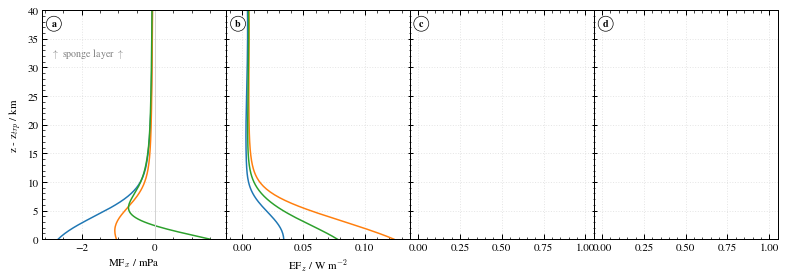

In [20]:
# - Vertical profiles - #

gskw = {'wspace':0}
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(11,4),sharey=True, gridspec_kw=gskw)

# --- SET TIME, Y AND VERTICAL AEQUIDISTANT GRID --- #
# x=480+53 # t=4 -> 400km (dx=7500m) // 
# x=480 # t=3
# x_range = 20 # -> mean over width of 300km
t=5 # t=3 -> 36h
# COLS=['darkblue','slateblue','darkviolet', 'mediumorchid', 'lightcoral','tomato', 'firebrick', 'black']
COLS=['black', 'blueviolet', 'goldenrod', 'firebrick', 'forestgreen', 'steelblue', 'olive', 'peru']
ZLIM = [0,40]
    
# --------- Calculate fluxes -------------------- # 
x = int(7000*1000/ds.dx00)
y=int(ds.ny/2)
z = np.linspace(0,ds['zcr'][t,-1,y,0].values,int(ds.nz)) # ds['dx']=200

nz_avg = 48 # *0.25km -> 12km
nx_avg = 33
print('xfilter: ', nx_avg*ds.dx00/1000)
print('zfilter: ', nz_avg*ds.dz00/1000)

# - Coriolis and dthdz for angular momentum flux calculation - #
f = ds.fcr0 * np.sin(ds.ang*np.pi/180)
print(f)

z_coord = np.linspace(0,ds.zcr[0,-1,0,0],ds.nz)*1000
the = ds['the'][t,:,y,:]
the = the.assign_coords(z_coord = ("z",z_coord))
dthdz = the.differentiate("z_coord")

# --------- Calculate fluxes -------------------- # 
uw   = ds['w'][t,:,y,:] * (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:])
uv   = ds['v'][t,:,y,:] * (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:])
vth   = ds['v'][t,:,y,:] * ds['th'][t,:,y,:]
vw   = ds['w'][t,:,y,:] * (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:])
mfx  = ds['rh0'][t,:,y,:] * uw # h9=h3*h6
mfx_ang = ds['rh0'][t,:,y,:] * (uw - f * (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:]) * ds['th'][t,:,y,:] / dthdz) ###########
mfx_ang2 = ds['rh0'][t,:,y,:] * (uw - uv - f * (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:]) * ds['th'][t,:,y,:] / dthdz) ###########
mfy  = ds['rh0'][t,:,y,:] * vw
mfy_ang = ds['rh0'][t,:,y,:] * (vw + f * (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:]) * ds['th'][t,:,y,:] / dthdz)
MF_U = mfx * ds['u'][t,:,y,:] - mfy * ds['v'][t,:,y,:] # = -EFz
MF_U_ang = mfx_ang * ds['u'][t,:,y,:] - mfy_ang * ds['v'][t,:,y,:]
MF_U_ang2 = mfx_ang2 * ds['u'][t,:,y,:] - mfy_ang * ds['v'][t,:,y,:]

efx = (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:]) * ds['pprime'][t,:,y,:] # h14, EFx1
efz = ds['w'][t,:,y,:] * ds['pprime'][t,:,y,:] # h13, EFz1

# -- TEMPERATURE CALCULATION -- #                             
thloc = ds['the'][t,:,y,:] + ds['th'][t,:,y,:] # Theta
# ds['tloc'] = ds['thloc']*(ds['ploc']/ds['pref00'])**ds.cap
tte = ds['the'][t,:,y,:]*(ds['pr0'][t,:,y,:]/ds['pref00'])**ds.cap # T_env
# tte = ds['the'][t,:,y,:]*(ds['ppe'][t,:,y,:]/ds['pref00'])**(2/24.4) # T_env
tloc = thloc*(ds['pr0'][t,:,y,:]/ds['pref00'])**ds.cap # T
tprime = tloc-tte

ep = 1/2*(ds.grav/ds.bv)**2 * (tprime/tte)**2 # * ds['rh0'][t,:,y,:] #  potential energy density
# --------- Calculate fluxes -------------------- # 

# --- INTERPOLATE TO AEQUIDISTANT GRID FOR FILTER ----- #
rho  = subroutines.interp_elev_to_z(ds['rh0'][t,:,y,:],ds.zcr[t,:,y,:],z)
u    = subroutines.interp_elev_to_z(ds['u'][t,:,y,:],ds.zcr[t,:,y,:],z)
v    = subroutines.interp_elev_to_z(ds['v'][t,:,y,:],ds.zcr[t,:,y,:],z)
uw   = subroutines.interp_elev_to_z(uw,ds.zcr[t,:,y,:],z)
uv   = subroutines.interp_elev_to_z(uv,ds.zcr[t,:,y,:],z)
vth  = subroutines.interp_elev_to_z(vth,ds.zcr[t,:,y,:],z)
vw   = subroutines.interp_elev_to_z(vw,ds.zcr[t,:,y,:],z)
mfx  = subroutines.interp_elev_to_z(mfx,ds.zcr[t,:,y,:],z)
mfx_ang2  = subroutines.interp_elev_to_z(mfx_ang2,ds.zcr[t,:,y,:],z)
mfy  = subroutines.interp_elev_to_z(mfy,ds.zcr[t,:,y,:],z)
mfy_ang  = subroutines.interp_elev_to_z(mfy_ang,ds.zcr[t,:,y,:],z)
efx  = subroutines.interp_elev_to_z(efx,ds.zcr[t,:,y,:],z)
efz  = subroutines.interp_elev_to_z(efz,ds.zcr[t,:,y,:],z)
ep   = subroutines.interp_elev_to_z(ep,ds.zcr[t,:,y,:],z)
MF_U = subroutines.interp_elev_to_z(MF_U,ds.zcr[t,:,y,:],z)
MF_U_ang = subroutines.interp_elev_to_z(MF_U_ang,ds.zcr[t,:,y,:],z)
MF_U_ang2 = subroutines.interp_elev_to_z(MF_U_ang2,ds.zcr[t,:,y,:],z)

# --- FFT OR RUNNING MEAN FILTER ------ #
mm = 1
# --- 2D filter --- # 
# uw=filter_2D(uw,nx_avg,nz_avg,mode=mm)
# mfx=filter_2D(mfx,nx_avg,nz_avg,mode=mm)
# ep=filter_2D(ep,nx_avg,nz_avg,mode=mm)

# --- 1D filter --- #
rho = subroutines.filter_1Dz(rho,nz_avg,mode=mm)
uw  = subroutines.filter_1Dz(uw,nz_avg,mode=mm)
uv  = subroutines.filter_1Dz(uv,nz_avg,mode=mm)
vth  = subroutines.filter_1Dz(vth,nz_avg,mode=mm)
vw  = subroutines.filter_1Dz(vw,nz_avg,mode=mm)
mfx = subroutines.filter_1Dz(mfx,nz_avg,mode=mm)
mfx_ang = subroutines.filter_1Dz(mfx_ang,nz_avg,mode=mm)
mfx_ang2 = subroutines.filter_1Dz(mfx_ang2,nz_avg,mode=mm)
mfy = subroutines.filter_1Dz(mfy,nz_avg,mode=mm)
mfy_ang = subroutines.filter_1Dz(mfy_ang,nz_avg,mode=mm)
ep  = subroutines.filter_1Dz(ep,nz_avg,mode=mm)
efx = subroutines.filter_1Dz(efx,nz_avg,mode=mm)
efz = subroutines.filter_1Dz(efz,nz_avg,mode=mm)
MF_U = subroutines.filter_1Dz(MF_U,nz_avg,mode=mm)
MF_U_ang = subroutines.filter_1Dz(MF_U_ang,nz_avg,mode=mm)
MF_U_ang2 = subroutines.filter_1Dz(MF_U_ang2,nz_avg,mode=mm)

# - Calc fluxes after interpolations and averaging/filtering - #
# mfx = rho*uw
# mfy = rho*vw
# MF_U = mfx*u + mfy*v

# --- Horizontal average / horizontal integration of fluxes --- #
if ds.irelx: # sponge layer left/right active 
    n_sponge=int(ds.dxabL/ds.dx00)
else: # cyclic boundaries
    n_sponge=0

# -> horizontal mean
uw_m = uw[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
uv_m = uv[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
vth_m = vth[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
vw_m = vw[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
mfx_m = mfx[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
mfx_ang_m = mfx_ang[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
mfx_ang_m2 = mfx_ang2[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
mfy_m = mfy[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
mfy_ang_m = mfy_ang[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
ep_m = ep[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
efx_m = efx[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
efz_m = efz[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
MF_U_m = MF_U[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
MF_U_ang_m = MF_U_ang[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
MF_U_ang_m2 = MF_U_ang2[:,n_sponge:ds.nx-n_sponge].mean(axis=1)

################################ VISUALIZATION #####################################
if i==0:
    lw = 3
    ls = '-'
else:
    lw = 1.5
    ls = '--'
    
ax0.plot(1000*mfx_m, z, lw=lw)
ax0.plot(1000*mfx_ang_m, z, lw=lw)
ax0.plot(1000*(mfx_ang_m-mfy_ang_m), z, lw=lw)
# ax0.plot(1000*mfx_ang_m2, z, lw=lw, ls=ls)

ax1.plot(efz_m, z, lw=lw)
ax1.plot(-MF_U_m, z, lw=lw)
ax1.plot(-MF_U_ang_m, z, lw=lw)
# ax1.plot(-MF_U_ang_m2, z, lw=lw, ls='dashed')

# ax0.plot(uv_m, z, lw=lw, ls=ls)
# ax3.plot(ds['th'][t,:,y,x]*ds['v'][t,:,y,x]/dthdz[:,x], ds.zcr[t,:,y,x], lw=lw, ls=ls) # N

# ax2.plot(efx_m, z, lw=lw, ls=ls, label=labels[i], color=COLS[i])
# ax2.plot(ep_m, z, lw=lw, label=labels[i], color=COLS[i])
# ax3.plot(ds['ue'][t,:,y,0], ds.zcr[t,:,y,0], lw=lw, ls=ls, color=COLS[i], label=labels[i])
################################ VISUALIZATION #####################################
    
# l = N/U # Scorer parameter


# -- FORMAT AXES -- #
ax0.set_xlabel("MF$_x$ / mPa")
ax1.set_xlabel("EF$_z$ / W m$^{-2}$")

# ax3.set_xlabel("u$_e$ / m s$^{-1}$")

ax0.yaxis.set_minor_locator(AutoMinorLocator())
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

ax0.tick_params(axis="y", which='both', right=False)
ax1.tick_params(axis="y", which='both', direction="inout", right=False)
ax2.tick_params(axis="y", which='both', direction="inout", right=False)
ax3.tick_params(axis="y", which='both', direction="inout", right=False)

# - SPONGE LAYER - #
lw_sponge = 1.5
hsponge = 48
ax0.axhline(y=hsponge, lw=lw_sponge,ls='--',color='grey')
ax1.axhline(y=hsponge, lw=lw_sponge,ls='--',color='grey')
ax2.axhline(y=hsponge, lw=lw_sponge,ls='--',color='grey')
ax3.axhline(y=hsponge, lw=lw_sponge,ls='--',color='grey')

sponge_label = r'$\uparrow$ sponge layer $\uparrow$'
ax0.text(0.05, 0.8, sponge_label, transform=ax0.transAxes, color='grey')

c3 = 'lightgrey'
htop = 73
alpha_sponge = 0.33
# axes[i,j].axhline(y=48, lw=1.5,ls='--',color='grey')
ax0.fill_between(ax0.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)
ax1.fill_between(ax1.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)
ax2.fill_between(ax2.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)
ax3.fill_between(ax3.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)


symb_ax = '-'
col_ax = 'lightgrey'
lw_ax = 1
ax0.axhline(y=0, lw=lw_ax,ls=symb_ax,color=col_ax)
ax1.axhline(y=0, lw=lw_ax,ls=symb_ax,color=col_ax)
ax2.axhline(y=0, lw=lw_ax,ls=symb_ax,color=col_ax)
ax3.axhline(y=0, lw=lw_ax,ls=symb_ax,color=col_ax)
ax0.axvline(x=0, lw=lw_ax,ls=symb_ax,color=col_ax)
ax0.axvline(x=0, lw=lw_ax,ls=symb_ax,color=col_ax)
ax0.axvline(x=0, lw=lw_ax,ls=symb_ax,color=col_ax)
ax0.axvline(x=0, lw=lw_ax,ls=symb_ax,color=col_ax)


# --- Labels and legend --- #
# ax3.legend(loc='lower right') # 'upper left'

ax0.set_ylim(ZLIM)
ax0.set_ylabel(r'z - z$_{trp}$ / km')
    
ax0.set_ylim(ZLIM)

ax0.grid(visible=True)
ax1.grid(visible=True)
ax2.grid(visible=True)
ax3.grid(visible=True)

# --- Text --- #
ax0.text(0.05, 0.93, 'a', transform=ax0.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax1.text(0.05, 0.93, 'b', transform=ax1.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax2.text(0.05, 0.93, 'c', transform=ax2.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax3.text(0.05, 0.93, 'd', transform=ax3.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})


# --- Save figure --- #
fig_title = 'Q3D-referenceSim-zprofiles.png'
fig.tight_layout()
fig.savefig('../figures/' + fig_title, facecolor='w', edgecolor='w',
                format='png', dpi=300, bbox_inches='tight')

In [ ]:
# vertical flux of wave energy should only change for varying U